<a href="https://colab.research.google.com/github/100495699/Clustering_/blob/main/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Eleccion Scaler

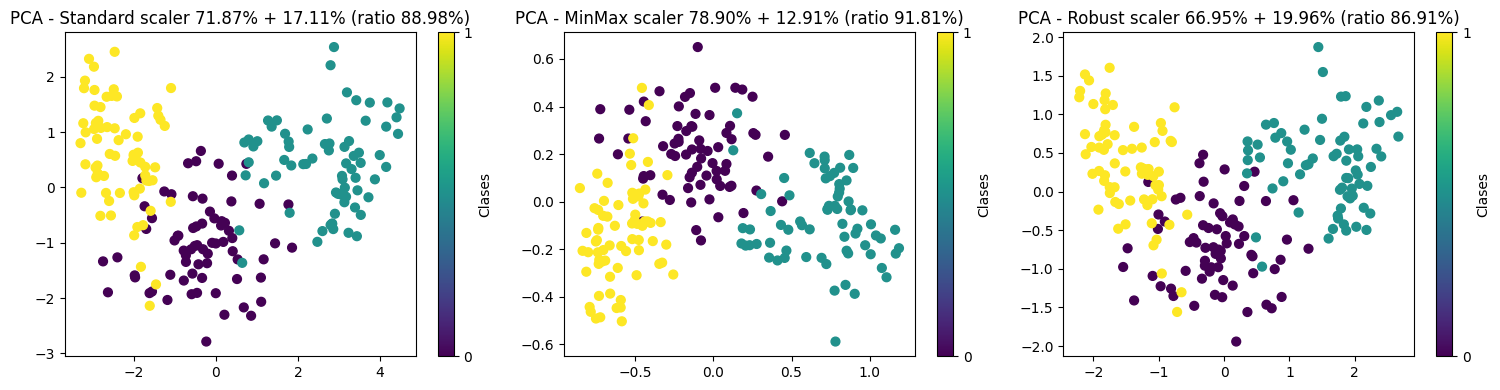

In [16]:
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
import matplotlib.pyplot as plt

dataset = pd.read_csv('semillas.csv')

dataset_p1 = dataset.copy()
dataset_p1 = dataset_p1.drop(columns=["clase"])
y = dataset["clase"]

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Siempre escalar antes de PCA
    ('pca', PCA(n_components=2))
])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))  # 1 fila, 3 columnas

# Transformar
X_reduced = pipeline.fit_transform(dataset_p1)
pca = pipeline.named_steps['pca']

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Visualizar
axes[0].scatter(X_reduced[:, 0], X_reduced[:, 1],c=y, s=40, cmap='viridis')
axes[0].set_title('PCA - Standard scaler {:.2%} + {:.2%} (ratio {:.2%})'.format(explained_variance[0], explained_variance[1], (explained_variance[0] + explained_variance[1])))
fig.colorbar(ticks=range(3), label='Clases', ax=axes[0], mappable=plt.cm.ScalarMappable(cmap='viridis'))

pipeline = Pipeline([
    ('scaler', MinMaxScaler()),  # Siempre escalar antes de PCA
    ('pca', PCA(n_components=2))
])

# Transformar
X_reduced = pipeline.fit_transform(dataset_p1)
pca = pipeline.named_steps['pca']

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Visualizar
axes[1].scatter(X_reduced[:, 0], X_reduced[:, 1],c=y, s=40, cmap='viridis')
axes[1].set_title('PCA - MinMax scaler {:.2%} + {:.2%} (ratio {:.2%})'.format(explained_variance[0], explained_variance[1], (explained_variance[0] + explained_variance[1])))
fig.colorbar(ticks=range(3), label='Clases', ax=axes[1], mappable=plt.cm.ScalarMappable(cmap='viridis'))



pipeline = Pipeline([
    ('scaler', RobustScaler()),  # Siempre escalar antes de PCA
    ('pca', PCA(n_components=2))
])

# Transformar
X_reduced = pipeline.fit_transform(dataset_p1)
pca = pipeline.named_steps['pca']

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)
# Visualizar
axes[2].scatter(X_reduced[:, 0], X_reduced[:, 1],c=y, s=40, cmap='viridis')
axes[2].set_title('PCA - Robust scaler {:.2%} + {:.2%} (ratio {:.2%})'.format(explained_variance[0], explained_variance[1], (explained_variance[0] + explained_variance[1])))
fig.colorbar(ticks=range(3), label='Clases', ax=axes[2], mappable=plt.cm.ScalarMappable(cmap='viridis'))


plt.tight_layout()
plt.show()

Mejor es: MinMax Scaler porque visualmente se ven las clases diferenciadas y tiene mayor varianza acumulada.

# K-Means

In [17]:
from sklearn.cluster import KMeans

# No usar la columna clase
dataset_kmeans = dataset.copy()
dataset_kmeans = dataset_kmeans.drop(columns=["clase"])
# y = dataset["clase"] # Definida en el bloque anterior

# Escalado de datos
pipeline = Pipeline([
    ('scaler', MinMaxScaler())
])
X_kmeans_scaled = pipeline.fit_transform(dataset_kmeans)

## Obtencion de K

### Metodo codo


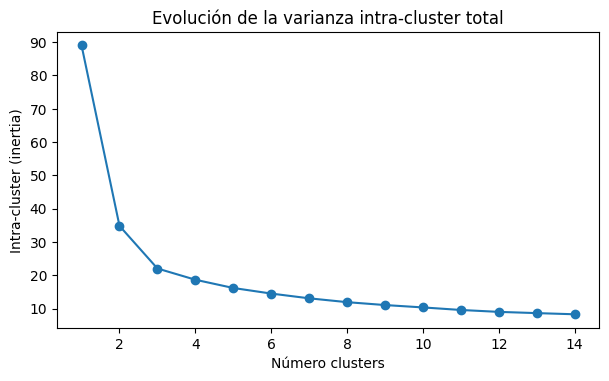

In [19]:
range_n_clusters = range(1, 15)
inertias = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 20,
        random_state = 42
    )
    modelo_kmeans.fit(X_kmeans_scaled)
    inertias.append(modelo_kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(7, 3.84))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)');

Se ve que el valor de K optimo es 3

### Metodo Silueta

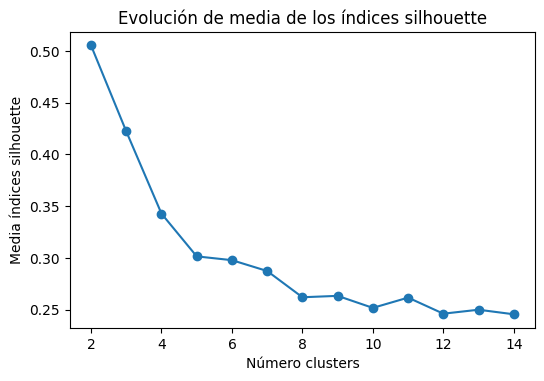

In [20]:
from sklearn.metrics import silhouette_score, silhouette_samples

range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 20,
        random_state = 123
    )
    cluster_labels = modelo_kmeans.fit_predict(X_kmeans_scaled)
    silhouette_avg = silhouette_score(X_kmeans_scaled, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

Segun esta aproximacion, el valor optimo de clusters es K=2

## Eleboración del modelo

Realizamos K-means para K=2 y K=3

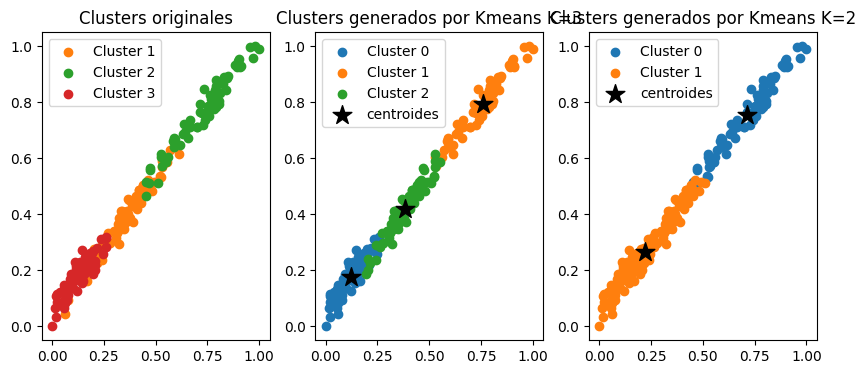

In [30]:


modelo_kmeans = KMeans(n_clusters=3, n_init=25, random_state=42)
modelo_kmeans.fit(X=X_kmeans_scaled)

modelo_kmeans2 = KMeans(n_clusters=2, n_init=25, random_state=42)
modelo_kmeans2.fit(X=X_kmeans_scaled)

y_kmeans_predict = modelo_kmeans.predict(X=X_kmeans_scaled)
y_kmeans_predict2 = modelo_kmeans2.predict(X=X_kmeans_scaled)

colores = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Pintamos los resultados junto con los originales
fig, ax = plt.subplots(1, 3, figsize=(10, 4))

for i in np.unique(y):
    ax[0].scatter(
        x = X_kmeans_scaled[y == i, 0],
        y = X_kmeans_scaled[y == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],

        marker    = 'o',
        label= f"Cluster {i}"
    )

ax[0].set_title('Clusters originales')
ax[0].legend();

for i in np.unique(y_kmeans_predict):
    ax[1].scatter(
        x = X_kmeans_scaled[y_kmeans_predict == i, 0],
        y = X_kmeans_scaled[y_kmeans_predict == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        label= f"Cluster {i}"
    )

ax[1].scatter(
    x = modelo_kmeans.cluster_centers_[:, 0],
    y = modelo_kmeans.cluster_centers_[:, 1],
    c = 'black',
    s = 200,
    marker = '*',
    label  = 'centroides'
)
ax[1].set_title('Clusters generados por Kmeans K=3')
ax[1].legend();

for i in np.unique(y_kmeans_predict2):
    ax[2].scatter(
        x = X_kmeans_scaled[y_kmeans_predict2 == i, 0],
        y = X_kmeans_scaled[y_kmeans_predict2 == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        label= f"Cluster {i}"
    )

ax[2].scatter(
    x = modelo_kmeans2.cluster_centers_[:, 0],
    y = modelo_kmeans2.cluster_centers_[:, 1],
    s = 200,
    marker = '*',
    c = 'black',
    label  = 'centroides'
)
ax[2].set_title('Clusters generados por Kmeans K=2')
ax[2].legend();

# Cluster jerárquico


In [33]:
# No usar la columna clase
dataset_cluster_jr = dataset.copy()
dataset_cluster_jr = dataset_cluster_jr.drop(columns=["clase"])
# y = dataset["clase"] # Definida en el bloque anterior

# Escalado de datos
pipeline = Pipeline([
    ('scaler', MinMaxScaler())
])
X_clusjr_scaled = pipeline.fit_transform(dataset_cluster_jr)

In [34]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

modelo_hclust_complete = AgglomerativeClustering(
    metric = 'euclidean',
    linkage  = 'complete',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_complete.fit(X=X_clusjr_scaled)

modelo_hclust_average = AgglomerativeClustering(
    metric = 'euclidean',
    linkage  = 'average',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_average.fit(X=X_clusjr_scaled)

modelo_hclust_ward = AgglomerativeClustering(
    linkage  = 'ward',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_ward.fit(X=X_clusjr_scaled)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

Funcion para representar el dendrograma

In [37]:
def plot_dendrogram(model, **kwargs):
    '''
    Esta función extrae la información de un modelo AgglomerativeClustering
    y representa su dendograma con la función dendogram de scipy.cluster.hierarchy
    '''

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot
    dendrogram(linkage_matrix, **kwargs)

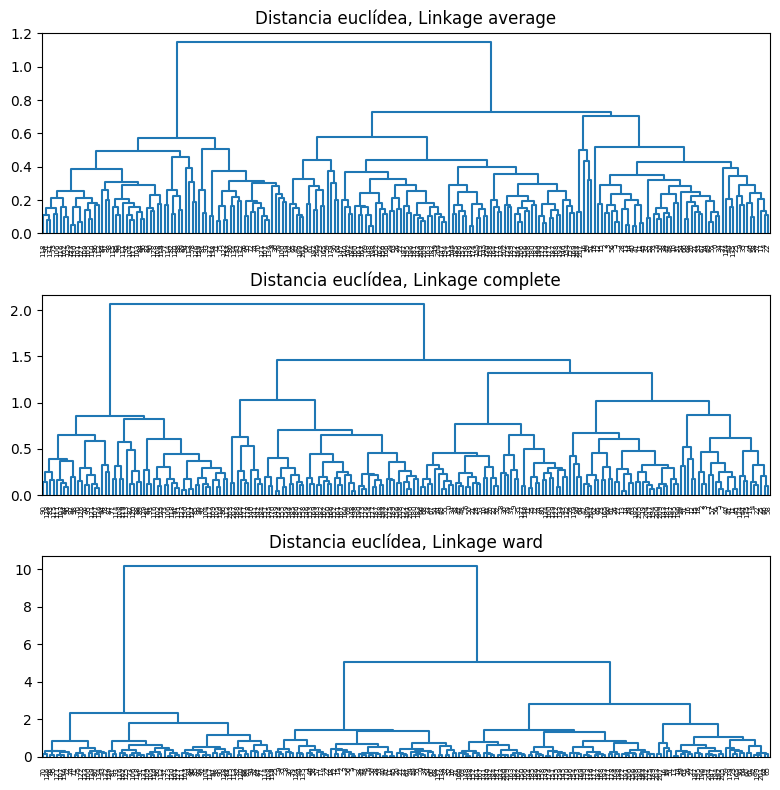

In [39]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8))
plot_dendrogram(modelo_hclust_average, labels=dataset_cluster_jr.index, color_threshold=0, ax=axs[0])
axs[0].set_title("Distancia euclídea, Linkage average")
plot_dendrogram(modelo_hclust_complete, labels=dataset_cluster_jr.index, color_threshold=0, ax=axs[1])
axs[1].set_title("Distancia euclídea, Linkage complete")
plot_dendrogram(modelo_hclust_ward, labels=dataset_cluster_jr.index, color_threshold=0, ax=axs[2])
axs[2].set_title("Distancia euclídea, Linkage ward")
plt.tight_layout();

# DBSCAN